In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt


def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(5)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install unrar
!unrar x /content/challenging_dataset.rar
x_train = np.load('/content/x_train.npy').reshape(27,50,5000)
y_train = np.load('/content/y_train.npy').reshape(-1,1)
x_val = np.load('/content/x_val.npy').reshape(27,10,5000)
y_val = np.load('/content/y_val.npy').reshape(-1,1)


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/challenging_dataset.rar

Extracting  x_train.npy                                                   82%  OK 
Extracting  x_val.npy                                                     99%  OK 
Extracting  y_test.npy                                                    99%  OK 
Extracting  y_train.npy                                                   99%  OK 
Extracting  y_val.npy                                                     99%  OK 
Extracting  x_test.npy                                                   100%  OK 
All OK


In [ ]:
from torch.utils.data import Dataset

rng = np.random.default_rng(seed=1)

class SiameseDataset(Dataset):

  def __init__(self, x, y, transform = None, number_of_samples = 50):
    self.x = x
    self.transform = transform
    self.y = y.reshape(-1)
    self.n = number_of_samples
    self.classes = np.arange(27)

  def __getitem__(self, idx):
    anchor = self.x[idx//self.n][idx % self.n]
    positive = rng.choice(self.x[idx//self.n])
    negative_idxs = np.delete(self.classes, self.classes == idx//self.n)
    negative_idx = np.random.choice(negative_idxs)
    negative = rng.choice(self.x[negative_idx])

    if self.transform is not None:
      anchor = self.transform(anchor)
      positive = self.transform(positive)
      negative = self.transform(negative)
    return anchor, positive, negative


  def __len__(self):
    return len(self.x)*self.n

from torch.utils.data import Dataset

class ValidationSiameseDataset(Dataset):

  def __init__(self, x, y, transform = None, number_of_samples = 10):
    self.x = x
    self.transform = transform
    self.y = y.reshape(-1)
    self.n = number_of_samples
    self.classes = np.arange(27)

  def __getitem__(self, idx):
    anchor = self.x[idx//self.n][idx % self.n]
    positive = rng.choice(self.x[idx//self.n])
    negative_idxs = np.delete(self.classes, self.classes == idx//self.n)
    negative_idx = np.random.choice(negative_idxs)
    negative = rng.choice(self.x[negative_idx])

    if self.transform is not None:
      anchor = self.transform(anchor)
      positive = self.transform(positive)
      negative = self.transform(negative)
    return anchor, positive, negative


  def __len__(self):
    return len(self.x)*self.n

def transformation(x):
  x = np.abs(x)
  x = x/np.max(x)
  x = x + np.random.normal(0,0.005,x.shape[0])
  x = torch.Tensor(x)
  return x

from torch import nn
class SiameseNet(nn.Module):

    def __init__(self, latent_dim):
      super().__init__()
      self.latent_dim = latent_dim
      self.model = nn.Sequential(nn.Conv1d(in_channels=1, out_channels=16,kernel_size=21, padding = 'same'),
                                  nn.MaxPool1d(kernel_size=2, stride=2),
                                  nn.LeakyReLU(),
                                  nn.BatchNorm1d(16),
                                  nn.Conv1d(16, 32, 11, padding = 'same'),
                                  nn.MaxPool1d(2, 2),
                                  nn.LeakyReLU(),
                                  nn.BatchNorm1d(32),
                                  nn.Conv1d(32, 64, 5, padding = 'same'),
                                  nn.MaxPool1d(2, 2),
                                  nn.LeakyReLU(),
                                  nn.BatchNorm1d(64),

                                 nn.Flatten(),
                                 nn.Linear(64*625, self.latent_dim))


    def _forward(self, x):
      out = x.view(-1, 1, 5000)
      out = self.model(out)
      # normalize embedding to unit vector
      out = torch.nn.functional.normalize(out)
      return out


    def predict(self, x):
      out = x.view(-1, 1, 5000)
      out = self.model(out)
      out = torch.nn.functional.normalize(out)
      return out

    def forward(self, anchor, positive, negative, latent_dim):
        output1 = self._forward(anchor)
        output2 = self._forward(positive)
        output3 = self._forward(negative)

        return output1, output2, output3



def train(num_epochs, model, criterion_train, criterion_val, optimizer, train_loader, val_loader, latent_dim):
    loss_history = []
    l = []
    l_val = []
    f_p_train = []
    f_p_val = []

    for epoch in range(0, num_epochs):
      model.train()
      for i, batch in enumerate(train_loader, 0):
          anc, pos, neg = batch
          output_anc, output_pos, output_neg = model(anc.to(device), pos.to(device), neg.to(device), latent_dim)
          loss, fraction_pos = criterion_train(output_anc, output_pos, output_neg)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          l.append(loss.item())
          f_p_train.append(fraction_pos.item())

      model.eval()
      for i, batch in enumerate(val_loader, 0):
          anc, pos, neg = batch
          output_anc, output_pos, output_neg = model(anc.to(device), pos.to(device), neg.to(device), latent_dim)
          loss_val, fraction_pos_val = criterion_val(output_anc, output_pos, output_neg)
          l_val.append(loss_val.item())
          f_p_val.append(fraction_pos_val.item())
      scheduler.step()
      f_p_train_last_ep =  torch.tensor(f_p_train[-len(train_loader):-1]).mean()
      f_p_val_last_ep = torch.tensor(f_p_val[-len(val_loader):-1]).mean()
      print("Epoch {} with {:.4f} fraction and {:.4f} val_fraction".format(epoch, f_p_train_last_ep, f_p_val_last_ep))

    return l, l_val, f_p_train, f_p_val

import torch.nn.functional as F
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin, semi_hard):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.semi_hard = semi_hard

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = 1.0 - F.cosine_similarity(anchor, positive)
        distance_negative = 1.0 - F.cosine_similarity(anchor, negative)
        losses = distance_positive - distance_negative + self.margin
        losses = torch.where(losses > self.semi_hard, losses, torch.zeros(losses.shape).to(device))
        return losses.sum()/(torch.count_nonzero(losses)+1e-16) if size_average else losses.sum(), torch.count_nonzero(losses)/len(losses)

In [ ]:
from torch.utils.data import  DataLoader

train_dataset = SiameseDataset(x_train, y_train, transform = transformation)
val_dataset = ValidationSiameseDataset(x_val, y_val, transform=transformation)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [ ]:
import torch.optim as optim
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
latent_dim = 64
model = SiameseNet(latent_dim).to(device)
criterion_train = TripletLoss(margin = 1, semi_hard = 0.3)
criterion_val = TripletLoss(margin = 1, semi_hard = 0.3)

optimizer = optim.AdamW(model.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,8,12,16], gamma=0.5)
num_epochs = 20

start = time.time()
l, l_val, f_p_train, f_p_val = train(num_epochs, model, criterion_train, criterion_val, optimizer, train_loader, val_loader, latent_dim)
elapsed = time.time() - start
print(f"Time: {elapsed} s")

Epoch 0 with 0.2711 fraction and 1.0000 val_fraction
Epoch 1 with 0.1281 fraction and 0.1328 val_fraction
Epoch 2 with 0.1367 fraction and 0.1445 val_fraction
Epoch 3 with 0.1109 fraction and 0.1406 val_fraction
Epoch 4 with 0.1008 fraction and 0.0703 val_fraction
Epoch 5 with 0.1008 fraction and 0.1172 val_fraction
Epoch 6 with 0.0930 fraction and 0.1094 val_fraction
Epoch 7 with 0.0977 fraction and 0.1016 val_fraction
Epoch 8 with 0.1039 fraction and 0.0938 val_fraction
Epoch 9 with 0.0961 fraction and 0.1445 val_fraction
Epoch 10 with 0.0867 fraction and 0.1094 val_fraction
Epoch 11 with 0.0883 fraction and 0.0742 val_fraction
Epoch 12 with 0.1016 fraction and 0.0820 val_fraction
Epoch 13 with 0.0867 fraction and 0.0820 val_fraction
Epoch 14 with 0.0922 fraction and 0.0781 val_fraction
Epoch 15 with 0.0914 fraction and 0.0898 val_fraction
Epoch 16 with 0.0781 fraction and 0.0977 val_fraction
Epoch 17 with 0.0883 fraction and 0.0859 val_fraction
Epoch 18 with 0.0828 fraction and 0.06

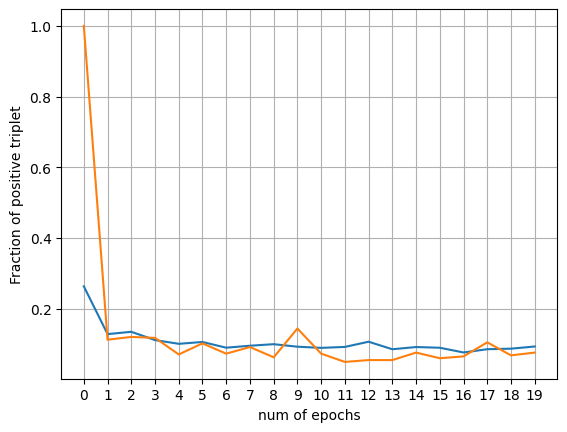

In [ ]:
l_plot_val = np.array(f_p_val).reshape(20, 3).mean(1)
l_plot_train = np.array(f_p_train).reshape(20, 11).mean(1)
plt.plot([i for i in range(len(l_plot_val))], l_plot_train, l_plot_val)
plt.ylabel('Fraction of positive triplet')
plt.xlabel('num of epochs')
x = range(0, len(l_plot_val), len(l_plot_val) // num_epochs)
labels = range(0, num_epochs)
plt.xticks(x, labels)
plt.grid()
plt.show()

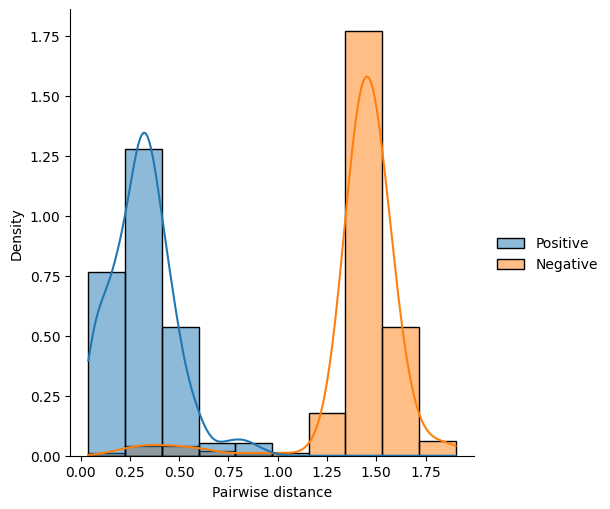

In [ ]:
import torch.nn.functional as F
def validate(model, val_loader, latent_dim):
    distances_pos = []
    distances_neg = []
    model.eval()

    for i, batch in enumerate(val_loader, 0):
        anc, pos, neg = batch
        output_anc, output_pos, output_neg = model(anc.to(device), pos.to(device), neg.to(device), latent_dim)

        distance_pos = F.pairwise_distance(output_anc, output_pos).detach().cpu()
        distance_neg = F.pairwise_distance(output_anc, output_neg).detach().cpu()

        distances_pos.append(distance_pos)
        distances_neg.append(distance_neg)

    return distances_pos, distances_neg


d_pos, d_neg = validate(model, val_loader, latent_dim = 64)
pos_dist = []
neg_dist = []
for d in d_pos[:-1]:
  d = d.detach().cpu().numpy()
  pos_dist.append(d)
for d in d_neg[:-1]:
  d = d.detach().cpu().numpy()
  neg_dist.append(d)
neg_dist = np.concatenate(np.array(neg_dist), axis=0, dtype = object)
pos_dist = np.concatenate(np.array(pos_dist), axis=0, dtype = object )

import seaborn as sns

distances = {"Positive": pos_dist, "Negative": neg_dist}

ax = sns.displot(distances, kde=True, stat="density")
ax.set(xlabel="Pairwise distance")
plt.show()

In [ ]:
def get_train_emb_and_label(x_train, y_train, model, num_classes=27):
    data_train = x_train.reshape(-1, 5000)
    row_max = data_train.max(axis=1)
    data_train = np.abs(data_train / row_max[:, np.newaxis])
    data_train = data_train.reshape(num_classes, -1, 5000)
    correct_train = y_train.reshape(num_classes,50)

    molecules_embedding = []
    label = []
    for i in range(0, data_train.shape[0]):
      molecules = torch.Tensor(data_train[i]).to(device)
      embedding = model.predict(molecules).detach().cpu().numpy()
      molecules_embedding.append(embedding)
      label.append([correct_train[i]])

    return np.array(molecules_embedding).reshape(-1, latent_dim), np.array(label).reshape(-1)


def get_test_emb_and_label(x_test, y_test, model):
    data_val = x_test.reshape(-1, 5000)
    row_max = data_val.max(axis=1)
    data_val = np.abs(data_val / row_max[:, np.newaxis])
    correct_val = y_test.reshape(-1, 1)

    data_val = torch.Tensor(data_val).to(device)
    classification_data_val = []
    classification_data_val =  model.predict(data_val).detach().cpu().numpy()

    classification_data_val = np.array(classification_data_val).reshape(len(data_val), latent_dim)
    return np.array(classification_data_val).reshape(len(data_val), latent_dim), correct_val

In [ ]:
molecules_embedding, label = get_train_emb_and_label(x_train, y_train, model)
classification_data_val, correct_val = get_test_emb_and_label(x_val, y_val, model)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
acc_arr = []
for i in range(1,51):
  neigh = KNeighborsClassifier(n_neighbors=i)
  neigh.fit(molecules_embedding, label)
  acc = neigh.score(classification_data_val, correct_val)
  acc_arr.append(acc)

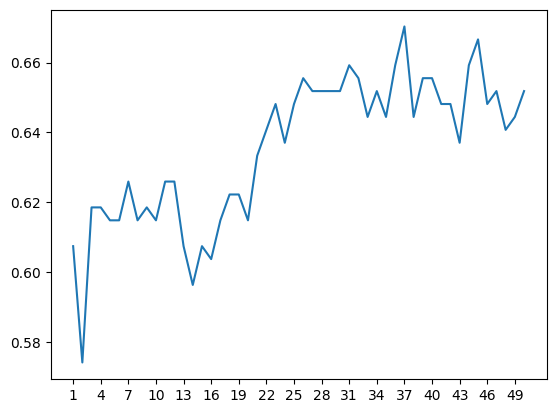

In [ ]:
plt.plot(range(1, 51), acc_arr)
plt.xticks(range(1, 51,3))
plt.show()

In [ ]:
best_acc, best_k = np.array(acc_arr).max(), np.array(acc_arr).argmax()+1
print(best_acc, best_k)

0.6703703703703704 37


In [ ]:
x_test = np.load('/content/x_test.npy')
y_test = np.load('/content/y_test.npy')

In [ ]:
molecules_embedding, label = get_train_emb_and_label(x_train, model)
classification_data_test, correct_test = get_test_emb_and_label(x_test, y_test, model)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(molecules_embedding, label)
acc = neigh.score(classification_data_test, correct_test)
print(acc)

0.5308641975308642


# Testing

In [ ]:
molecules_embedding, label = get_train_emb_and_label(x_train[18:], y_train[18*50:], model, num_classes=9)
classification_data_val, correct_val = get_test_emb_and_label(x_val[18:], y_val[18*10:], model)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
acc_arr = []
for i in range(1,51):
  neigh = KNeighborsClassifier(n_neighbors=i)
  neigh.fit(molecules_embedding, label)
  acc = neigh.score(classification_data_val, correct_val)
  acc_arr.append(acc)

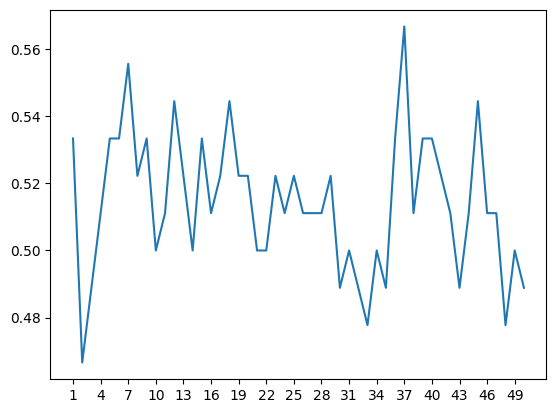

In [ ]:
plt.plot(range(1, 51), acc_arr)
plt.xticks(range(1, 51,3))
plt.show()

# PCA

In [ ]:
from sklearn.preprocessing import StandardScaler

molecules_embedding_st = StandardScaler().fit_transform(molecules_embedding)
molecules_embedding_st_plot = molecules_embedding[:450]

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced_plot = pca.fit_transform(molecules_embedding_st_plot)

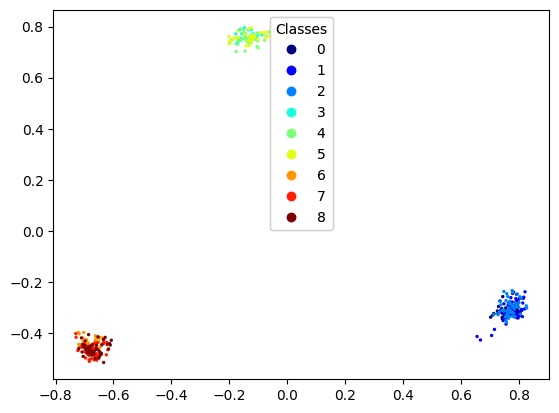

In [ ]:
fig, ax = plt.subplots()

scatter = ax.scatter(X_reduced_plot[:, 0], X_reduced_plot[:, 1], c=label[:450], s=2, cmap='jet')

legend1 = ax.legend(*scatter.legend_elements(num=9),
                    loc="upper center", title="Classes")
ax.add_artist(legend1)

In [ ]:
from sklearn.decomposition import PCA

molecules_embedding_st_plot = molecules_embedding[450:900]
pca = PCA(n_components=2)
X_reduced_plot = pca.fit_transform(molecules_embedding_st_plot)

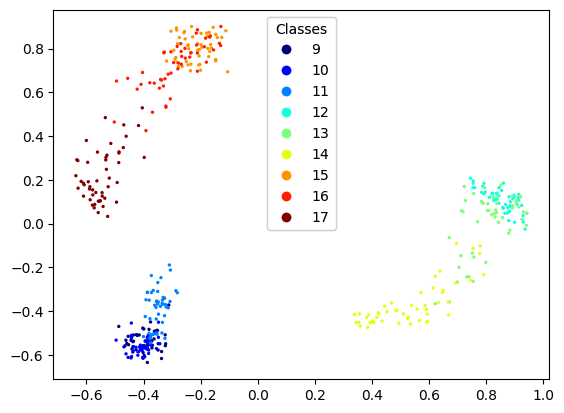

In [ ]:
fig, ax = plt.subplots()

scatter = ax.scatter(X_reduced_plot[:, 0], X_reduced_plot[:, 1], c=label[450:900], s=2, cmap='jet')

legend1 = ax.legend(*scatter.legend_elements(num=9),
                    loc="upper center", title="Classes")
ax.add_artist(legend1)

In [ ]:
from sklearn.decomposition import PCA

molecules_embedding_st_plot = molecules_embedding[900:1350]
pca = PCA(n_components=2)
X_reduced_plot = pca.fit_transform(molecules_embedding_st_plot)

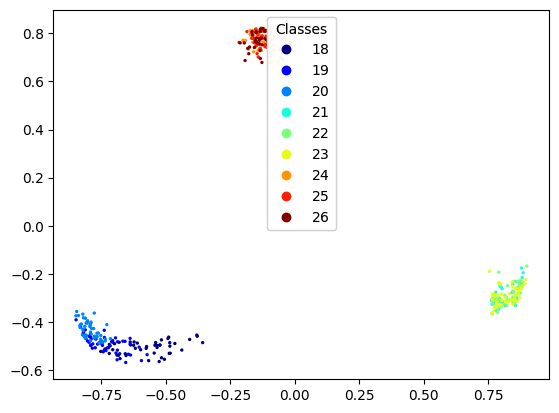

In [ ]:
fig, ax = plt.subplots()

scatter = ax.scatter(X_reduced_plot[:, 0], X_reduced_plot[:, 1], c=label[900:1350], s=2, cmap='jet')

legend1 = ax.legend(*scatter.legend_elements(num=9),
                    loc="upper center", title="Classes")
ax.add_artist(legend1)